**This notebook is a explanation of the problem, a discussion of the background and a description of the data.**

# Background
COVID-19 is caused by a coronavirus called SARS-CoV-2. Older adults and people who have severe underlying medical conditions like heart or lung disease or diabetes seem to be at higher risk for developing more serious complications from COVID-19 illness.  
In 2020, COVID-19 outbroke severely in the whole world. New York City is one of the most affected areas. Up to date, there are 6,226,409 confirmed cases worldwide, 1,835,300 of them are in the United State, while New York City itself has 203,303 confirmed cases.


# Problem

In this project, we will explore insights and interesting information about the correlation between location data and COVID-19 data by neighborhoods in New York City, to see how they affect each other. 



# Data


### data-zsnEP.csv
This dataset includes the Cases, Cases per 100,000, Deaths per 100,000 and Percent of people tested who tested positive of Covid-19 by zip code within New York City. 

Source:[NYC Health] https://www1.nyc.gov/site/doh/covid/covid-19-data.page



### Foursquare API
Based on the zip code, cooridinates of the areas and venues within 500 meters are collected through Foursquare API, including venue name, venue Latitude, venue Longitude and venue category.

<br>

<br>
Code used to read and collectdata is below 


In [1]:
# import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import folium 
import requests

In [5]:
# load coronavirus data
covi_df = pd.read_csv('data-zsnEP.csv')
covi_df.head()

,ZIP,Neighborhood,Borough,Cases,"Cases per 100,000","Deaths per 100,000",Percent of people tested who tested positive
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,361,1532.06,89.12,17.38
1,10002,Chinatown/Lower East Side,Manhattan,1035,1348.44,188.91,23.88
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,445,827.11,59.48,14.23
3,10004,Financial District,Manhattan,31,849.17,27.39,14.69
4,10005,Financial District,Manhattan,61,726.53,23.82,12.45


In [45]:
# Foursquare information
CLIENT_ID = 'AHEDMVAJIUDVUSPU1MANS5NFCQT5LKEYRP05GGJR5X0QEY0P' 
CLIENT_SECRET = 'XSSELRMELFJWGJJRKT4U4RQC45OVHADU1NX22PIOA3L0EBB0' 
VERSION = '20200304'

In [46]:
# get the coordinates from zip codes
covi_df['latitude']=None
covi_df['longitude']=None

for i in range(len(covi_df)):
    location = geolocator.geocode(str(covi_df.ZIP[i])+',US')
    covi_df['latitude'][i] = location.latitude
    covi_df['longitude'][i] = location.longitude

C:\Users\40463\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\40463\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [51]:
covi_df.head()

,ZIP,Neighborhood,Borough,Cases,"Cases per 100,000","Deaths per 100,000",Percent of people tested who tested positive,latitude,longitude
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,361,1532.06,89.12,17.38,40.7506,-73.998
1,10002,Chinatown/Lower East Side,Manhattan,1035,1348.44,188.91,23.88,40.7223,-73.9877
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,445,827.11,59.48,14.23,40.7316,-73.9885
3,10004,Financial District,Manhattan,31,849.17,27.39,14.69,40.7007,-74.0135
4,10005,Financial District,Manhattan,61,726.53,23.82,12.45,40.7056,-74.0089


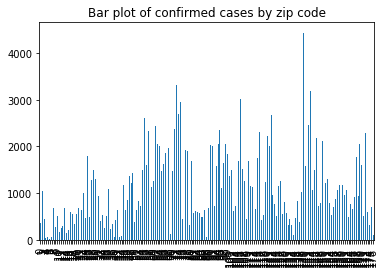

In [67]:
# data visualization
covi_df['Cases'].plot(kind='bar',title='Bar plot of confirmed cases by zip code')

You can see from the bar plot above that the numbers of confirmed case are sparse. Some neighborhoods has obvious a lot more cases than the other ones.

In [101]:
# Choropleth maps
district_geo='https://data.beta.nyc/dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson'

ny_map = folium.Map(location=[40.7128,-74.0060],zoom_start=15)
ny_map.choropleth(geo_data = district_geo,
                  name='choropleth',
              data = covi_df,
              columns = ['Neighborhood', 'Cases'],
              key_on = 'feature.properties.neighborhood',
              fill_color = 'YlOrRd', 
              fill_opacity = 0.7, 
              line_opacity = 0.2,
              legend_name = 'Cases')
               
folium.LayerControl().add_to(ny_map)
ny_map



In [63]:
# get the nearby stores categories

def getNearbyVenues(postalcode,latitudes, longitudes, radius=500, LIMIT=30):
    
    venues_list=[]
    for code,lat, lng in zip(postalcode,latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([( 
            code,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

df_venues = getNearbyVenues(postalcode=covi_df['ZIP'],latitudes=covi_df['latitude'],longitudes=covi_df['longitude'])

In [64]:
df_venues.head()

,ZIP,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,Bluestone Lane,40.752068,-73.998848,Coffee Shop
1,10001,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
2,10001,You Should Be Dancing…..! / Club 412,40.750306,-73.994743,Dance Studio
3,10001,B&H Photo Video,40.753277,-73.996470,Camera Store
4,10001,Music Choice,40.752632,-73.994585,Music Venue


In [102]:
df_venues.to_csv('Newyork_venues.csv')
covi_df.to_csv('Covid_ny_co.csv')